<a href="https://colab.research.google.com/github/pelinbalci/Tinyml_Occupancy_Detection/blob/main/Occupancy_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this colab, I will use the Occupancy Detection Data Set to generate TensorFlow and TensorFlow Lite models. 

**The problem is:**

Recognize whether someone is in the room or not based on measurements of temperature, humidity, light, and CO2. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.

**Features and Target**
- Temperature Humidity
- Light
- CO2
- Humidity Ratio
- Occupancy – 0 - not occupied; 1 - occupied status.

**Content of the Notebook:**

- Data Analysis: read and analyze the dataset.
- Prepare Data: prepare & normalize data to training phase 
- Tensor Flow Model: Train data with tensorflow model
- TensorFlow Lite Model Explanation: Explain each step for tflite model
- Converted model with no quantization
- Convert using dynamic range quantization
- Convert using float fallback quantization
- Convert using integer-only quantization
- Create Quantization Aware Model
- Summary: Compare the tensorflow model with tensorflow lite models

**References:**

[1] https://colab.research.google.com/github/tinyMLx/colabs/blob/master/3-3-12-QAT.ipynb

[2] https://www.tensorflow.org/lite/performance/post_training_integer_quant

[3] https://studymachinelearning.com/model-quantization-methods-in-tensorflow-lite/

[4] https://towardsdatascience.com/tensorflow-on-arduino-b336f08fa0e9

[5] https://www.youtube.com/watch?v=HXzz87WVm6c

Data: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+# 

The dataset is preprocessed earlier: The DateTime column was deleted before training. Then the original dataset was divided into train and test sets before training.

# Data Analysis

Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_set = pd.read_csv('/content/occupancy_detection_training.csv')
data_set_test = pd.read_csv('/content/occupancy_detection_valid.csv')

In [3]:
data_set.head(5)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,22.600000,17.166667,140.666667,446.000000,0.002904,0
1,19.633333,30.100000,226.000000,423.000000,0.004253,0
2,21.500000,20.840000,528.500000,832.500000,0.003299,1
3,22.200000,21.290000,528.666667,895.333333,0.003518,1
4,22.100000,38.200000,433.000000,1880.000000,0.006303,1


In [4]:
data_set_test.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,20.29,26.175000,60.75,417.750000,0.003850,0
1,22.10,37.817500,426.00,1801.750000,0.006239,1
2,19.23,30.533333,24.00,435.000000,0.004207,0
3,22.29,26.100000,112.75,898.500000,0.004343,0
4,21.50,33.290000,471.00,1255.333333,0.005286,1


In [5]:
print('training:', data_set.shape)
print('test:', data_set_test.shape)

training: (2215, 6)
test: (554, 6)


In [6]:
print(data_set.isnull().sum())

print(data_set_test.isnull().sum())


Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64


In [7]:
print(data_set.Occupancy.value_counts())

0    1149
1    1066
Name: Occupancy, dtype: int64


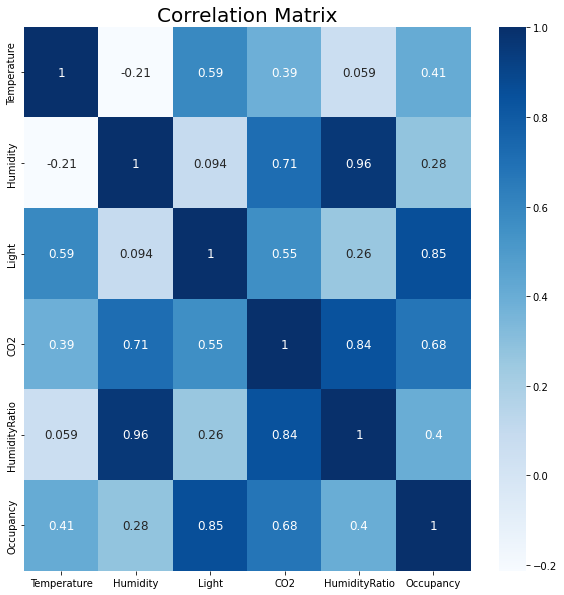

In [8]:
# Correlation Matrix
correlation_matrix = data_set.corr()

# plot correlation matrix
plt.figure(figsize=(10,10))
plt.title("Correlation Matrix",fontsize=20)
sns.heatmap(correlation_matrix, annot= True, cmap="Blues", annot_kws={'size':12})
plt.show()

# Prepare Data

In [9]:
from sklearn.preprocessing import StandardScaler

Create train set features & labels

In [10]:
data = data_set.drop('Occupancy',axis=1)
labels = data_set[["Occupancy"]]

data_test = data_set_test.drop('Occupancy',axis=1)
labels_test = data_set_test[["Occupancy"]]

train_data_ = np.array(data)
train_labels = np.array(labels)
test_data_ = np.array(data_test)
test_labels = np.array(labels_test)

print('Train data shape: {}, train labels shape: {}'.format(train_data_.shape, train_labels.shape))
print('Test data shape: {}, test labels shape: {}'.format(test_data_.shape, test_labels.shape))

Train data shape: (2215, 5), train labels shape: (2215, 1)
Test data shape: (554, 5), test labels shape: (554, 1)


Scale the Data

In [11]:
scale = StandardScaler()
scale.fit(train_data_)

train_data = scale.transform(train_data_)
test_data = scale.transform(test_data_)

In [12]:
train_data

array([[ 1.10391568, -1.432334  , -0.67742672, -0.8983183 , -1.21584681],
       [-1.73766119,  0.70109186, -0.26955001, -0.95220737,  0.17930207],
       [ 0.05029729, -0.82639707,  1.17634106,  0.00725247, -0.80753074],
       ...,
       [-0.15084804, -0.76701305,  0.8441446 , -0.00446255, -0.79289515],
       [ 0.57710648, -1.30394355, -1.04865826, -0.9041758 , -1.18284387],
       [ 1.48704964, -1.48896876, -0.4464028 , -0.90534731, -1.20360973]])

In [13]:
train_labels

array([[0],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

# Tensor Flow Model

In [14]:
import tempfile
import os
import tensorflow as tf
from tensorflow import keras
import pathlib
import numpy as np
tf.random.set_seed(15687)

In [15]:
! pip install -q tensorflow-model-optimization

I will collect the results in dict_summary.

In [16]:
dict_summary = {}

Load data, build, compile and fit TensorFlow model

I'm using the default learning rate: 0.001 If you want to change the learning rate, use this code: 

    tf.keras.optimizers.Adam(learning_rate=0.1)

Ref: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [17]:
# Define the model architecture.
model = keras.Sequential([
      keras.layers.Dense(64, activation='relu', input_dim=train_data.shape[1]),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(1, activation="sigmoid")
])

# Train the occupancy data
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_data, train_labels, epochs=10, validation_split=0.1)

_, baseline_model_accuracy = model.evaluate(
    test_data, test_labels, verbose=0)

print(baseline_model_accuracy)

Epoch 1/10
63/63 [==============================] - 2s 8ms/step - loss: 0.4153 - accuracy: 0.9247 - val_loss: 0.1475 - val_accuracy: 0.9775
Epoch 2/10
63/63 [==============================] - 0s 3ms/step - loss: 0.1204 - accuracy: 0.9719 - val_loss: 0.0915 - val_accuracy: 0.9775
Epoch 3/10
63/63 [==============================] - 0s 3ms/step - loss: 0.1025 - accuracy: 0.9719 - val_loss: 0.0836 - val_accuracy: 0.9775
Epoch 4/10
63/63 [==============================] - 0s 3ms/step - loss: 0.0958 - accuracy: 0.9719 - val_loss: 0.0787 - val_accuracy: 0.9775
Epoch 5/10
63/63 [==============================] - 0s 3ms/step - loss: 0.0905 - accuracy: 0.9719 - val_loss: 0.0746 - val_accuracy: 0.9775
Epoch 6/10
63/63 [==============================] - 0s 3ms/step - loss: 0.0864 - accuracy: 0.9709 - val_loss: 0.0724 - val_accuracy: 0.9775
Epoch 7/10
63/63 [==============================] - 0s 3ms/step - loss: 0.0815 - accuracy: 0.9719 - val_loss: 0.0693 - val_accuracy: 0.9775
Epoch 8/10
63/63 [==

## How to save model & calculate size?

You can save the model by model.save() or tf.saved_model.save(model, saved_model_path). 


You can get the file size by: os.path.getsize  and it gives you bytes. If you want to get megabytes you need to divide it to 2^20 which gives you ~1M

In [18]:
# save model - first way
model.save('model.h5')

# save model - second way
saved_model_path = 'saved_model/1'
tf.saved_model.save(model, saved_model_path)

# Get file size in bytes for a given model - first way
TF_model_size = os.path.getsize('model.h5') /float(2**10)
print('TF_model_size in KB', TF_model_size)

dict_summary['TensorFlow Model'] = {}
dict_summary['TensorFlow Model']['Accuracy'] = baseline_model_accuracy
dict_summary['TensorFlow Model']['Size'] = TF_model_size

INFO:tensorflow:Assets written to: saved_model/1/assets
TF_model_size in KB 79.6015625


# TensorFlow Lite Model Explanation



## How can we convert model?
There are 3 types of conversion:
- from saved model 
- from keras model
- from concrete functions

**from saved model:**

In [19]:
converter_1 = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model_1 = converter_1.convert()

**from keras model:**

In [20]:
converter_ = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_ = converter_.convert()

INFO:tensorflow:Assets written to: /tmp/tmp9wr5fws2/assets


INFO:tensorflow:Assets written to: /tmp/tmp9wr5fws2/assets


In [21]:
loaded_model = tf.keras.models.load_model('model.h5')
converter_2 = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model_2 = converter_2.convert()

INFO:tensorflow:Assets written to: /tmp/tmp0miq749v/assets


INFO:tensorflow:Assets written to: /tmp/tmp0miq749v/assets


## How can we save tflite model?

Define the path then, use write_bytes to save the tflite model.

In [22]:
tflite_model_file = pathlib.Path("/tmp/saved_tflitemodel.tflite")
print(tflite_model_file)
tflite_model_file.write_bytes(tflite_model_1)

/tmp/saved_tflitemodel.tflite


16376

## How can we evaluate the results and make predictions?

The evaluation is very simple in terms of tensorflow models. Simply, the evaluation is completed with model.evaluate() and you can use model.predict() for prediction. However, making evaluation for tensorflowlite model is a bit complicated. 

The full code for predicting a sample test data is below:

In [23]:
# Convert Model
converter_1 = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model_1 = converter_1.convert()


# Save TFLite Model
tflite_model_file = pathlib.Path("/tmp/saved_tflitemodel.tflite")
print(tflite_model_file)
tflite_model_file.write_bytes(tflite_model_1)

# Load TFLite Model and Allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model_1)
interpreter.allocate_tensors()

#Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Take a test_data to predict
test_data_0 = test_data[0]
test_label_0 = test_labels[0]

# Point the data to be used for testing and run the interpreter
trial_test_data = np.expand_dims(test_data_0, axis=0).astype(input_details[0]["dtype"])
interpreter.set_tensor(input_details[0]['index'], trial_test_data)

# Run inference.
interpreter.invoke()

# Get output
output = interpreter.get_tensor(output_details[0]['index'])
print(output)

predicted_label = 0 if output <0.5 else 1
print(predicted_label)

print(test_label_0)

/tmp/saved_tflitemodel.tflite
[[0.00010062]]
0
[0]


Let's look at the details. 

- At first, take a sample data:

In [24]:
test_data_0 = test_data[0]
test_label_0 = test_labels[0]

print('dtype {}, shape{}'.format(test_data_0.dtype, test_data_0.shape))

dtype float64, shape(5,)


- Instantiate the interpreter

In [25]:
# Load TFLite Model and Allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model_1)

# Load TFLite Model with path
tflite_model_file_dir = '/tmp/saved_tflitemodel.tflite'                
interpreter = tf.lite.Interpreter(model_path=tflite_model_file_dir)

# Allocate tensors
interpreter.allocate_tensors()

#Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

- What information does input_details store?

In [26]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_dense_input:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 5], dtype=int32),
  'shape_signature': array([-1,  5], dtype=int32),
  'sparsity_parameters': {}}]

- The size of the data that interpreter expects: [1,5]

Now we need to expand the dimension of test_data to meet the expected shape:

In [27]:
trial_test_data = np.expand_dims(test_data_0, axis=0).astype(input_details[0]["dtype"])
print('dtype {}, shape{}'.format(trial_test_data.dtype, trial_test_data.shape))

dtype float32, shape(1, 5)


- What if I don't check the dtype and shape?

In [28]:
# interpreter.set_tensor(input_details[0]['index'], test_data_0)

"""
ValueError: Cannot set tensor: Got value of type FLOAT64 but expected type FLOAT32 for input 0, name: serving_default_dense_18_input:0 
"""

'\nValueError: Cannot set tensor: Got value of type FLOAT64 but expected type FLOAT32 for input 0, name: serving_default_dense_18_input:0 \n'

In [29]:
# interpreter.set_tensor(input_details[0]['index'], test_data_0.astype(input_details[0]["dtype"]))

"""
ValueError: Cannot set tensor: Dimension mismatch. Got 1 but expected 2 for input 0.
"""

'\nValueError: Cannot set tensor: Dimension mismatch. Got 1 but expected 2 for input 0.\n'

- Next, we set the tensor for the trial test data. And then invoke the interpreter, it is like model.predict().

In [30]:
# Point the data to be used for testing and run the interpreter
interpreter.set_tensor(input_details[0]['index'], trial_test_data)

# Run inference.
interpreter.invoke()

In [31]:
# Get output
output = interpreter.get_tensor(output_details[0]['index'])
print(output)

predicted_label = 0 if output <0.5 else 1
print(predicted_label)

print(test_label_0)

[[0.00010062]]
0
[0]


## Put them all together

Make prediction for all test data and calculate accuracy: 

In [32]:
# Create Float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

# Write tflite model to path
tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(float_tflite_model)

#Evaluate results with model
interpreter_1 = tf.lite.Interpreter(model_content=float_tflite_model)

input_details = interpreter_1.get_input_details()
output_details = interpreter_1.get_output_details()

interpreter_1.resize_tensor_input(input_details[0]['index'], test_data.shape)
interpreter_1.resize_tensor_input(output_details[0]['index'], test_labels.shape)
interpreter_1.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# test_data_np = np.expand_dims(test_data, axis=0).astype(input_details[0]["dtype"])
test_data_np = np.array(test_data, dtype=np.float32)
print(test_data_np.shape)
print(input_details[0]['shape'])
interpreter_1.set_tensor(input_details[0]['index'], test_data_np)

# Run inference.
interpreter_1.invoke()

# Post-processing: remove batch dimension and find the digit with highest
# probability.
output = interpreter_1.get_tensor(output_details[0]['index'])
predicted_label =np.where(output<0.5, 0, 1)   # np.array(0 if output <0.5 else 1)
print(predicted_label.shape, test_labels.shape)

print('\n')
# Compare prediction results with ground truth labels to calculate accuracy.
acc = (np.array(predicted_label) == test_labels).mean()
print('Accuracy:', acc)

# Measure sizes of models.
tflite_model_file_dir = '/tmp/model1.tflite'    
no_quant_size = os.path.getsize(tflite_model_file_dir) / float(2**10)
print("model size in kb:", no_quant_size)

INFO:tensorflow:Assets written to: /tmp/tmpc8tdhibx/assets


INFO:tensorflow:Assets written to: /tmp/tmpc8tdhibx/assets


(554, 5)
[1 5]
(554, 1) (554, 1)


Accuracy: 0.9783393501805054
model size in kb: 15.9921875


Make prediction for all test data and calculate accuracy (second way): 

In [33]:
# Create Float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

# Write tflite model to path
tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(float_tflite_model)

#Evaluate results with model
interpreter_1 = tf.lite.Interpreter(model_content=float_tflite_model)

input_index = interpreter.get_input_details()[0]
output_index = interpreter.get_output_details()[0]

# Run predictions on every data in the "test" dataset.
prediction_labels = []
outputs = []
for i, test_data_i in enumerate(test_data):
  # Pre-processing: convert to float32 to match with the model's input data format.
  test_data_i = np.expand_dims(test_data_i, axis=0).astype(input_index["dtype"])
  interpreter.set_tensor(input_index['index'], test_data_i)

  # Run inference.
  interpreter.invoke()

  # Post-processing: remove batch dimension and find the digit with highest
  # probability.
  output = interpreter.get_tensor(output_index['index'])
  outputs.append(output)
  predicted_label = 0 if output <0.5 else 1
  prediction_labels.append(predicted_label)

print('\n')
# Compare prediction results with ground truth labels to calculate accuracy.
accuracy = (np.array(prediction_labels) == test_labels.reshape(1,-1)).mean()
print(accuracy)

INFO:tensorflow:Assets written to: /tmp/tmpz0pm_pvs/assets


INFO:tensorflow:Assets written to: /tmp/tmpz0pm_pvs/assets




0.9783393501805054


## Define Evaluate functions

In [34]:
def evaluate_model(interpreter):
  input_details = interpreter_1.get_input_details()
  output_details = interpreter_1.get_output_details()

  interpreter_1.resize_tensor_input(input_details[0]['index'], test_data.shape)
  interpreter_1.resize_tensor_input(output_details[0]['index'], test_labels.shape)
  interpreter_1.allocate_tensors()

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # test_data_np = np.expand_dims(test_data, axis=0).astype(input_details[0]["dtype"])
  test_data_np = np.array(test_data, dtype=np.float32)
  print(test_data_np.shape)
  print(input_details[0]['shape'])
  interpreter_1.set_tensor(input_details[0]['index'], test_data_np)

  # Run inference.
  interpreter_1.invoke()

  # Post-processing: remove batch dimension and find the digit with highest
  # probability.
  output = interpreter_1.get_tensor(output_details[0]['index'])
  predicted_label =np.where(output<0.5, 0, 1)   # np.array(0 if output <0.5 else 1)
  print(predicted_label.shape, test_labels.shape)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  accuracy = (np.array(predicted_label) == test_labels).mean()
  return accuracy

In [35]:
def evaluate_model_2(interpreter):
  input_index = interpreter.get_input_details()[0]
  output_index = interpreter.get_output_details()[0]

  # Run predictions on every data in the "test" dataset.
  prediction_labels = []
  outputs = []
  for i, test_data_i in enumerate(test_data):
    # Pre-processing: convert to float32 to match with the model's input data format.
    test_data_i = np.expand_dims(test_data_i, axis=0).astype(input_index["dtype"])
    interpreter.set_tensor(input_index['index'], test_data_i)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.get_tensor(output_index['index'])
    outputs.append(output)
    predicted_label = 0 if output <0.5 else 1
    prediction_labels.append(predicted_label)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  accuracy = (np.array(prediction_labels) == test_labels.reshape(1,-1)).mean()
  return accuracy

# Converted model with no quantization

It's now a TensorFlow Lite model, but it's still using 32-bit float values for all parameter data. [1]

In [36]:
# Create Float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

# Write tflite model to path
tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(float_tflite_model)

#Evaluate results with model
interpreter_1 = tf.lite.Interpreter(model_content=float_tflite_model)
interpreter_1.allocate_tensors()
test_accuracy_1 = evaluate_model_2(interpreter_1)

#Evaluate results with model path
tflite_model_file_dir = '/tmp/model1.tflite'                
interpreter_1 = tf.lite.Interpreter(model_path=tflite_model_file_dir)
interpreter_1.allocate_tensors()
test_accuracy_trial = evaluate_model_2(interpreter_1)
print('Accuracy:', test_accuracy_1, test_accuracy_trial)

# Measure sizes of models.
no_quant_size = os.path.getsize(tflite_model_file_dir) / float(2**10)
print("model size in kb:", no_quant_size)


dict_summary['TFLite_no_quantization'] = {}
dict_summary['TFLite_no_quantization']['Accuracy'] = test_accuracy_1
dict_summary['TFLite_no_quantization']['Size'] = no_quant_size

INFO:tensorflow:Assets written to: /tmp/tmphyhr18gv/assets


INFO:tensorflow:Assets written to: /tmp/tmphyhr18gv/assets






Accuracy: 0.9783393501805054 0.9783393501805054
model size in kb: 15.9921875


# Convert using dynamic range quantization

Now let's enable the default optimizations flag to quantize all fixed parameters (such as weights).

The model is now a bit smaller with quantized weights, but other variable data is still in float format. [1]

In [37]:
# Create TFLite model
converter_dynamic = tf.lite.TFLiteConverter.from_keras_model(model) 
converter_dynamic.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_dynamic = converter_dynamic.convert()

# Write tflite model to path
tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir/'model2.tflite'
tflite_model_file.write_bytes(tflite_model_dynamic)

#Evaluate results with model
interpreter_2 = tf.lite.Interpreter(model_content=tflite_model_dynamic)
interpreter_2.allocate_tensors()
test_accuracy_2 = evaluate_model_2(interpreter_2)
print('Optimize tflite acc:', test_accuracy_2)

# Measure sizes of models.
tflite_model_file_dir = '/tmp/model2.tflite'   
dynamic_range_quant_size = os.path.getsize(tflite_model_file_dir) / float(2**10)
print("model in kb:", dynamic_range_quant_size)


dict_summary['Dynamic_range_quantization'] = {}
dict_summary['Dynamic_range_quantization']['Accuracy'] = test_accuracy_2
dict_summary['Dynamic_range_quantization']['Size'] = dynamic_range_quant_size

INFO:tensorflow:Assets written to: /tmp/tmpbr0qjpvz/assets


INFO:tensorflow:Assets written to: /tmp/tmpbr0qjpvz/assets




Optimize tflite acc: 0.9783393501805054
model in kb: 7.234375


# Convert using float fallback quantization

"To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a **RepresentativeDataset**. 

This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.) 

To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices." [1]

Ref: https://stackoverflow.com/questions/59855961/converting-keras-model-with-tfliteconverter-to-quantized-tflite-version-results

In [38]:
def representative_data_gen():
  for i in range(100):
    yield [test_data[i].astype(np.float32)]

# Convert model
converter_rep = tf.lite.TFLiteConverter.from_keras_model(model)
converter_rep.optimizations = [tf.lite.Optimize.DEFAULT]
converter_rep.representative_dataset = representative_data_gen
tflite_model_quant_rep = converter_rep.convert()

# Write tflite model to path
tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir/'model3.tflite' 
tflite_model_file.write_bytes(tflite_model_quant_rep)

#Evaluate results with model
interpreter_3 = tf.lite.Interpreter(model_content=tflite_model_quant_rep)
interpreter_3.allocate_tensors()
test_accuracy_3 = evaluate_model_2(interpreter_3)
print('Optimize tflite acc:', test_accuracy_3)


# Measure sizes of models.
tflite_models_dir = tflite_models_dir/'model3.tflite'
float_fallback_quant_size = os.path.getsize(tflite_models_dir) / float(2**10)
print("model in kb:", float_fallback_quant_size)


dict_summary['Representative_Dataset_Float_Fallback'] = {}
dict_summary['Representative_Dataset_Float_Fallback']['Accuracy'] = test_accuracy_3
dict_summary['Representative_Dataset_Float_Fallback']['Size'] = float_fallback_quant_size

INFO:tensorflow:Assets written to: /tmp/tmpipsl4vyt/assets


INFO:tensorflow:Assets written to: /tmp/tmpipsl4vyt/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "




Optimize tflite acc: 0.9783393501805054
model in kb: 6.75


# Convert using integer-only quantization

To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with some additional parameters: [1]

**The only difference from the previous cell is:**

    converter_rep_.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter_rep_2.inference_input_type = tf.uint8
    converter_rep_2.inference_output_type = tf.uint8

In [39]:
def representative_data_gen():
  for i in range(100):
    yield [test_data[i].astype(np.float32)]

converter_rep_ = tf.lite.TFLiteConverter.from_keras_model(model)
converter_rep_.optimizations = [tf.lite.Optimize.DEFAULT]
converter_rep_.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
# Restricting supported target op specification to INT8
converter_rep_.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter_rep_.inference_input_type = tf.uint8
converter_rep_.inference_output_type = tf.uint8

tflite_model_quant_ = converter_rep_.convert()


# Write tflite model to path
tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir/'model4.tflite' 
tflite_model_file.write_bytes(tflite_model_quant_)

#Evaluate results with model
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_)
interpreter.allocate_tensors()
test_accuracy_4 = evaluate_model_2(interpreter)
print('Optimize tflite acc:', test_accuracy_4)

# Measure sizes of models.
tflite_models_dir = tflite_models_dir/'model4.tflite' 
integer_quant_size = os.path.getsize(tflite_models_dir) / float(2**10)
print("model in kb:", integer_quant_size)


dict_summary['Representative_Dataset_Int_Only'] = {}
dict_summary['Representative_Dataset_Int_Only']['Accuracy'] = test_accuracy_4
dict_summary['Representative_Dataset_Int_Only']['Size'] = integer_quant_size

INFO:tensorflow:Assets written to: /tmp/tmpzw_tbaib/assets


INFO:tensorflow:Assets written to: /tmp/tmpzw_tbaib/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "




Optimize tflite acc: 0.33393501805054154
model in kb: 6.7734375


# Create Quantization Aware Model

You will apply quantization aware training to the whole model and see this in the model summary. All layers are now prefixed by "quant".

Note that the resulting model is quantization aware but not quantized (e.g. the weights are float32 instead of int8). The sections after show how to create a quantized model from the quantization aware one.

In the [comprehensive guide](https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide.md), you can see how to quantize some layers for model accuracy improvements. [2]

In [40]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()


q_aware_model.fit(train_data, train_labels, epochs=10, validation_split=0.1)

_, q_aware_model_accuracy = q_aware_model.evaluate(
   test_data, test_labels, verbose=0)

print(baseline_model_accuracy, q_aware_model_accuracy)


model.save('q_aware_model.h5')
# Get file size in bytes for a given model
q_aware_model_size = os.path.getsize('q_aware_model.h5') /float(2**10)

dict_summary['Q_Aware Model'] = {}
dict_summary['Q_Aware Model']['Accuracy'] = q_aware_model_accuracy
dict_summary['Q_Aware Model']['Size'] = q_aware_model_size

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 5)                3         
 er)                                                             
                                                                 
 quant_dense (QuantizeWrappe  (None, 64)               389       
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 32)               2085      
 perV2)                                                          
                                                                 
 quant_dense_2 (QuantizeWrap  (None, 32)               1061      
 perV2)                                                          
                                                                 
 quant_dense_3 (QuantizeWrap  (None, 1)                3

In [41]:
# Create TFLite model
converter_aware = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter_aware.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter_aware.convert()

# Write tflite model to path
tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir/'model5.tflite' 
tflite_model_file.write_bytes(quantized_tflite_model)


#Evaluate results with model
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()
test_accuracy_quant = evaluate_model_2(interpreter)

print('Quant TFLite test_accuracy:', test_accuracy_quant)
print('Quant TF test accuracy:', q_aware_model_accuracy)


# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
with open(float_file, 'wb') as f:
  f.write(quantized_tflite_model)

quantize_aware_size = os.path.getsize(float_file) / float(2**10)
print("model in kb:", integer_quant_size)


dict_summary['Quantize_Aware_TFLite'] = {}
dict_summary['Quantize_Aware_TFLite']['Accuracy'] = test_accuracy_quant
dict_summary['Quantize_Aware_TFLite']['Size'] = quantize_aware_size


INFO:tensorflow:Assets written to: /tmp/tmpnewqfhm7/assets


INFO:tensorflow:Assets written to: /tmp/tmpnewqfhm7/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "




Quant TFLite test_accuracy: 0.9909747292418772
Quant TF test accuracy: 0.9909747242927551
model in kb: 6.7734375


# Summary

Below, accuracies and sizes of TensorFlow model and Tensorflow Lite Models are prenseted. As you can see, the accuracy doesn't change with quantization. Qauntization aware training gives better results. It is an expected behaviour since it learns from errors during training and give more robust parameters. Integer only quantization gives very low accuracy which is Representative_Dataset_Int_Only. 


In [42]:
import pandas as pd
pd.DataFrame.from_dict(dict_summary).T

,Accuracy,Size
TensorFlow Model,0.978339,79.601562
TFLite_no_quantization,0.978339,15.992188
Dynamic_range_quantization,0.978339,7.234375
Representative_Dataset_Float_Fallback,0.978339,6.750000
Representative_Dataset_Int_Only,0.333935,6.773438
Q_Aware Model,0.990975,79.601562
Quantize_Aware_TFLite,0.990975,7.218750


In [43]:
summary = pd.DataFrame.from_dict(dict_summary).T.reset_index()
summary.rename(columns={'index': 'Model'}, inplace=True)
summary = summary[summary.Model != 'Representative_Dataset_Int_Only']

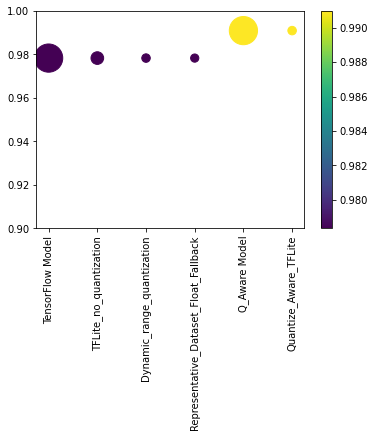

In [44]:
plt.scatter(summary.Model, summary.Accuracy, c=summary.Accuracy, s=summary.Size*10)
plt.ylim(ymax = 1, ymin = 0.9)
plt.xticks(rotation = 90)
plt.colorbar()
plt.show()